In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Load data from JSON file
path = './sample_data/tournament_dataset.json'
with open(path) as json_file:
    data = json.load(json_file)

# Extract values from JSON data
match_statistic = []
for line in data:
    for key, value in line.items():
        match_statistic.append(value)

# Create a DataFrame from the extracted data
df = pd.DataFrame.from_dict(match_statistic)

In [4]:
# Split the DataFrame into two halves
df1 = df.iloc[:df.shape[0] // 2]
df2 = df.iloc[df.shape[0] // 2:]

In [5]:
# Function to split match score
def split_score(df, winner):
    num_rows = df.shape[0]
    P1_T1_S1, P2_T2_S1, P1_T1_S2, P2_T2_S2, P1_T1_S3, P2_T2_S3 = [[0] * num_rows for _ in range(6)]
    i = 0
    for row in df.MatchScore: # row: 21-12, 12-21, 21-7
        row = row.split(",")
        if len(row) == 1:
            i += 1
        elif len(row) == 2:
            set1 = row[0].strip().split("-")
            P1_T1_S1[i] = set1[0].strip()
            P2_T2_S1[i] = set1[1].strip()
            if row[1].strip() != "-":
                set2 = row[1].strip().split("-")
                P1_T1_S2[i] = set2[0].strip()
                P2_T2_S2[i] = set2[1].strip()
            i += 1
        else:
            set1 = row[0].strip().split("-")
            P1_T1_S1[i] = set1[0].strip()
            P2_T2_S1[i] = set1[1].strip()

            set2 = row[1].strip().split("-")
            P1_T1_S2[i] = set2[0].strip()
            P2_T2_S2[i] = set2[1].strip()
            if row[2].strip() != "-":
                set3 = row[2].strip().split("-")
                P1_T1_S3[i] = set3[0].strip()
                P2_T2_S3[i] = set3[1].strip()
            i += 1
    df['P1/T1-S1'], df['P2/T2-S1'] = P1_T1_S1, P2_T2_S1
    df['P1/T1-S2'], df['P2/T2-S2'] = P1_T1_S2, P2_T2_S2
    df['P1/T1-S3'], df['P2/T2-S3'] = P1_T1_S3, P2_T2_S3
    df['Winner'] = winner
    df.drop(columns='MatchScore', inplace=True)
    return df


In [6]:
# Apply the split_score function to both halves of the DataFrame
df1 = split_score(df1, 1)
df2 = split_score(df2, 0)
df2.rename(columns={'P1': 'P2', 'P1-C': 'P2-C', 'P2': 'P1', 'P2-C': 'P1-C', 'P1T1': 'P1T2', 'P2T1': 'P2T2',\
                    'P1T1-C': 'P1T2-C', 'P2T1-C': 'P2T2-C', 'P1T2': 'P1T1', 'P2T2': 'P2T1', 'P1T2-C': 'P1T1-C',\
                    'P2T2-C': 'P2T1-C', 'P1/T1-TP': 'P2/T2-TP', 'P2/T2-TP': 'P1/T1-TP', 'P1/T1-L': 'P2/T2-L',
                    'P2/T2-L': 'P1/T1-L', 'P1/T1-W': 'P2/T2-W', 'P2/T2-W': 'P1/T1-W', 'P1/T1-GP': 'P2/T2-GP',
                    'P2/T2-GP': 'P1/T1-GP', 'P1/T1-LP': 'P2/T2-LP', 'P2/T2-LP': 'P1/T1-LP', 'P1-H2H': 'P2-H2H',
                    'P2-H2H': 'P1-H2H', 'P1/T1-S': 'P2/T2-S', 'P2/T2-S': 'P1/T1-S'})

<ipython-input-5-c0fa6c373d39>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P1/T1-S1'], df['P2/T2-S1'] = P1_T1_S1, P2_T2_S1
<ipython-input-5-c0fa6c373d39>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P1/T1-S1'], df['P2/T2-S1'] = P1_T1_S1, P2_T2_S1
<ipython-input-5-c0fa6c373d39>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,Y,T,P2/T2-TP,P1/T1-TP,P2/T2-L,P1/T1-L,P2/T2-W,P1/T1-W,P2/T2-GP,P1/T1-GP,...,P1/T1-S,P2-H2H,P1-H2H,P1/T1-S1,P2/T2-S1,P1/T1-S2,P2/T2-S2,P1/T1-S3,P2/T2-S3,Winner
2956,2022,43,47,40,40,47,2,0,2,5,...,1,2,3,21,16,26,24,0,0,0
2957,2022,76,62,54,54,62,2,1,3,3,...,6,1,0,22,20,19,21,21,13,0
2958,2022,40,42,33,33,42,2,0,3,0,...,3,1,0,21,15,21,18,0,0,0
2959,2022,34,42,18,18,42,2,0,2,0,...,3,1,0,21,13,21,5,0,0,0
2960,2021,38,42,32,32,42,2,0,2,0,...,0,11,4,21,14,21,18,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5908,2022,37,42,26,26,42,2,0,2,0,...,0,6,0,21,13,21,13,0,0,0
5909,2022,37,42,26,26,42,2,0,3,0,...,6,9,4,21,16,21,10,0,0,0
5910,2022,59,42,34,34,42,2,0,3,0,...,1,1,15,21,19,21,15,0,0,0
5911,2022,69,57,52,52,57,2,1,3,4,...,3,4,5,15,21,21,17,21,14,0


In [7]:
df = pd.concat([df1, df2])

In [8]:
# Replace specific values in the DataFrame
df = df.replace({'duration:': 0, '-': 0})

In [9]:
df.columns

Index(['Y', 'T', 'P1/T1-TP', 'P2/T2-TP', 'P1/T1-L', 'P2/T2-L', 'P1/T1-W',
       'P2/T2-W', 'P1/T1-GP', 'P2/T2-GP', 'P1/T1-LP', 'P2/T2-LP', 'P1', 'P1-C',
       'P1T1', 'P1T1-C', 'P2T1', 'P2T1-C', 'P1/T1-S', 'P2', 'P2-C', 'P1T2',
       'P1T2-C', 'P2T2', 'P2T2-C', 'P2/T2-S', 'P1-H2H', 'P2-H2H', 'P1/T1-S1',
       'P2/T2-S1', 'P1/T1-S2', 'P2/T2-S2', 'P1/T1-S3', 'P2/T2-S3', 'Winner'],
      dtype='object')

In [10]:
# Convert certain columns to integer type
df = df.astype({"T": int, "P1/T1-TP": int, "P2/T2-TP": int, "P1/T1-L": int, "P2/T2-L": int, "P1/T1-W": int,
                "P2/T2-W": int, "P1/T1-GP": int, "P2/T2-GP": int, "P1/T1-LP": int, "P2/T2-LP": int, "P1-H2H": int,
                "P2-H2H": int, "P1/T1-S1": int, "P2/T2-S1": int, "P1/T1-S2": int, "P2/T2-S2": int, "P1/T1-S3": int,
                "P2/T2-S3": int, 'P1/T1-S': int, 'P2/T2-S': int})

In [11]:
year_categories = sorted(df['Y'].unique())
cat_dtype_year = pd.CategoricalDtype(categories=year_categories, ordered=True)
cat_dtype_seed = pd.CategoricalDtype(categories=[1, 2, 3, 4, 5, 6, 7, 8, 0], ordered=True)

# Assign the Categorical data type back to the column
df['Y'] = df['Y'].astype(cat_dtype_year)
df['P1/T1-S'] = df['P1/T1-S'].astype(cat_dtype_seed)
df['P2/T2-S'] = df['P2/T2-S'].astype(cat_dtype_seed)

In [12]:
# Create subsets for singles and doubles matches and drop irrelevant columns
df_single_match = df[~df['P1-C'].isnull()].drop(columns=['P1', 'P2', 'P1T1', 'P1T1-C', 'P2T1', 'P2T1-C', 'P2T2', 'P2T2-C', 'P1T2', 'P1T2-C'])
df_double_match = df[df['P1-C'].isnull()].drop(columns=['P1', 'P1-C', 'P2', 'P2-C', 'P1T1', 'P2T1', 'P2T2', 'P1T2'])

In [13]:
countries = ['CHN', 'KOR', 'JPN', 'INA', 'IND', 'DEN', 'MAS', 'THA', 'TPE'] # top 8th countries in badminton
            #  'FRA', 'CAN', 'GER', 'SGP', 'HKG', 'USA', 'ENG', 'NED', 'ESP', \
            #  'BRA', 'SCO', 'AUS', 'BUL', 'EGY', 'GUA', 'UKR']

# Helper function to map countries to predefined categories
def change_columns_country(df, columns, function):
    for column in columns:
        df[column] = df[column].apply(function)

# Apply country mapping to relevant columns in singles and doubles datasets
change_columns_country(df_single_match, ['P1-C', 'P2-C'], lambda country: country if country in countries else 'OTHERS')
change_columns_country(df_double_match, ['P1T1-C', 'P2T1-C', 'P2T2-C', 'P1T2-C'], lambda country: country if country in countries else 'OTHERS')

In [14]:
# Define categorical data type with the top 8 countries as categories
cat_dtype_country = pd.CategoricalDtype(categories=countries)

In [15]:
# Prepare features and labels for the singles match dataset
X = df_single_match.drop(columns=['Winner'])
y = df_single_match['Winner']

# Split the data into training, validation, and test sets
X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size= 0.15, random_state=42, shuffle=True)

In [16]:
# Define a preprocessor for categorical feature encoding
single_match_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Y', 'P1-C', 'P2-C', 'P1/T1-S', 'P2/T2-S'])
    ]
)

# Function to create a machine learning pipeline with a specified model
def pipeline(name, model):
    return Pipeline([
    ('preprocessor', single_match_preprocessor),
    (name, model)
])

# Define models and their respective hyperparameter grids
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}
param_grids = {
    'Logistic Regression': {
        'Logistic Regression__penalty': ['l1', 'l2'],
        'Logistic Regression__C': [0.1, 1, 10],
        'Logistic Regression__solver': ['liblinear']
    },
    'Random Forest': {
        'Random Forest__n_estimators': [100, 200, 300],
        'Random Forest__max_depth': [None, 5, 10, 20]
    },
    'Gradient Boosting': {
        'Gradient Boosting__n_estimators': [100, 200, 300],
        'Gradient Boosting__learning_rate': [0.1, 0.05, 0.01],
        'Gradient Boosting__max_depth': [3, 5, 7]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10],
        'SVM__kernel': ['linear', 'rbf']
    },
    'XGBoost': {
        'XGBoost__n_estimators': [100, 200, 300],
        'XGBoost__learning_rate': [0.1, 0.05, 0.01],
        'XGBoost__max_depth': [3, 5, 7]
    }
}

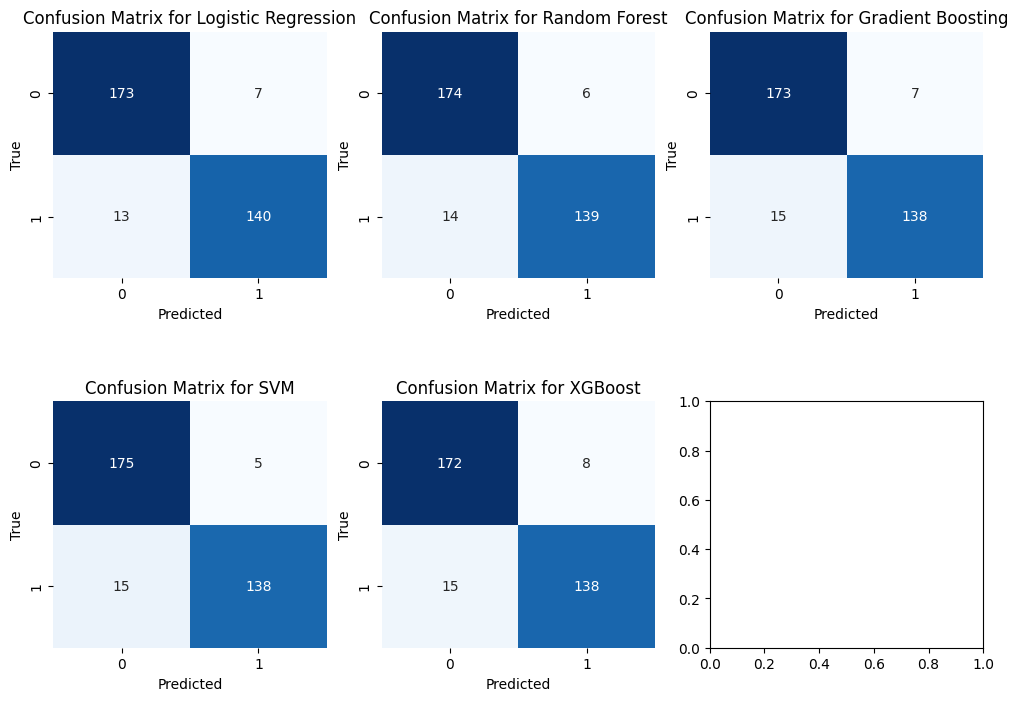

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [17]:
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix for {model_name}')


row, col = 0, 0

# Calculate and plot confusion matrices for each model
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing between subplots

# Create empty dictionaries to store the results
model_comparison = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
}
best_models = {}
pipelines = []

for name, model in models.items():
    pipelines.append((name, pipeline(name, model)))

for model_name, model_pipe in pipelines:
    grid_search = GridSearchCV(model_pipe, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_
    y_pred = best_models[model_name].predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, best_models[model_name].predict_proba(X_test)[:, 1])

    model_comparison['Model'].append(model_name)
    model_comparison['Accuracy'].append(accuracy)
    model_comparison['Precision'].append(precision)
    model_comparison['Recall'].append(recall)
    model_comparison['F1-Score'].append(f1)
    # model_comparison['AUC-ROC'].append(roc_auc)
    if col == 3:
        row += 1
        col = 0

    ax = axes[row, col]
    plot_confusion_matrix(y_test, y_pred, model_name, ax)
    col += 1

for i in range(len(models), 3):
    fig.delaxes(axes[1, i])

plt.show()

In [18]:
# Create a Pandas DataFrame from the results
result_model = pd.DataFrame(model_comparison)

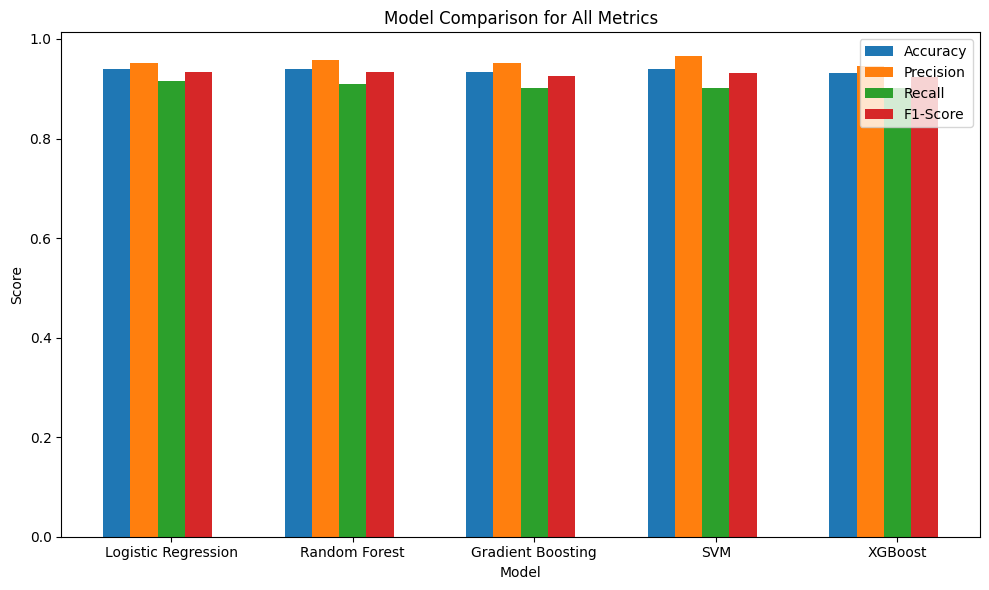

In [19]:
result_model.set_index('Model', inplace=True)

# Create a grouped bar chart to visualize all metrics
plt.figure(figsize=(10, 6))
metrics = result_model.columns
models = result_model.index
width = 0.15  # Width of each bar

for i, metric in enumerate(metrics):
    x = range(len(models))
    plt.bar([pos + i * width for pos in x], result_model[metric], width=width, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Comparison for All Metrics')
plt.xticks([pos + width * 2 for pos in x], models)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
X = df_double_match.drop(columns=['Winner'])
y = df_double_match['Winner']
X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size= 0.15, random_state=42, shuffle=True)

In [21]:
double_match_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Y','P1T1-C', 'P2T1-C', 'P1T2-C', 'P2T2-C'])
    ]
)

def pipeline(name, model):
    return Pipeline([
    ('preprocessor', double_match_preprocessor),
    (name, model)
])

models = {
    'Logistic Regression Double': LogisticRegression(random_state=42),
    'Random Forest Double': RandomForestClassifier(random_state=42),
    'Gradient Boosting Double': GradientBoostingClassifier(random_state=42),
    'SVM Double': SVC(random_state=42),
    'XGBoost Double': XGBClassifier(random_state=42),
}
param_grids = {
    'Logistic Regression Double': {
        'Logistic Regression Double__penalty': ['l1', 'l2'],
        'Logistic Regression Double__C': [0.1, 1, 10],
        'Logistic Regression Double__solver': ['liblinear']
    },
    'Random Forest Double': {
        'Random Forest Double__n_estimators': [100, 200, 300],
        'Random Forest Double__max_depth': [None, 5, 10, 20]
    },
    'Gradient Boosting Double': {
        'Gradient Boosting Double__n_estimators': [100, 200, 300],
        'Gradient Boosting Double__learning_rate': [0.1, 0.05, 0.01],
        'Gradient Boosting Double__max_depth': [3, 5, 7]
    },
    'SVM Double': {
        'SVM Double__C': [0.1, 1, 10],
        'SVM Double__kernel': ['linear', 'rbf']
    },
    'XGBoost Double': {
        'XGBoost Double__n_estimators': [100, 200, 300],
        'XGBoost Double__learning_rate': [0.1, 0.05, 0.01],
        'XGBoost Double__max_depth': [3, 5, 7]
    }
}

In [22]:
best_models = {}
pipelines = []
for name, model in models.items():
    pipelines.append((name, pipeline(name, model)))

for model_name, model_pipe in pipelines:
    grid_search = GridSearchCV(model_pipe, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_
    y_pred = best_models[model_name].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best {model_name} Model Accuracy: {accuracy:.2f}")

Best Logistic Regression Double Model Accuracy: 0.92
Best Random Forest Double Model Accuracy: 0.92
Best Gradient Boosting Double Model Accuracy: 0.92
Best SVM Double Model Accuracy: 0.92
Best XGBoost Double Model Accuracy: 0.92
